In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader ,random_split
import matplotlib.pyplot as plt
from torch.nn import functional as F
from PIL import Image

In [15]:
num_classes = 15
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [16]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset', transform=transform)


In [17]:
num_train = int(len(full_dataset) * (0.8))
num_valid = len(full_dataset) - num_train
train_dataset, valid_dataset = random_split(full_dataset, [num_train, num_valid])

In [18]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)

In [22]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [23]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')


Epoch [1/10], Train Loss: 2.6588, Train Acc: 0.1260, Valid Loss: 2.4954, Valid Acc: 0.2005
Epoch [2/10], Train Loss: 2.3713, Train Acc: 0.2296, Valid Loss: 2.2645, Valid Acc: 0.2571
Epoch [3/10], Train Loss: 2.1084, Train Acc: 0.3235, Valid Loss: 2.1231, Valid Acc: 0.2931
Epoch [4/10], Train Loss: 1.7517, Train Acc: 0.4585, Valid Loss: 1.8170, Valid Acc: 0.4370
Epoch [5/10], Train Loss: 1.3930, Train Acc: 0.5743, Valid Loss: 1.7433, Valid Acc: 0.4730
Epoch [6/10], Train Loss: 1.0928, Train Acc: 0.6797, Valid Loss: 1.5233, Valid Acc: 0.5141
Epoch [7/10], Train Loss: 0.8122, Train Acc: 0.7723, Valid Loss: 1.5158, Valid Acc: 0.5733
Epoch [8/10], Train Loss: 0.6037, Train Acc: 0.8257, Valid Loss: 1.3458, Valid Acc: 0.6607
Epoch [9/10], Train Loss: 0.3828, Train Acc: 0.9151, Valid Loss: 1.3301, Valid Acc: 0.6761
Epoch [10/10], Train Loss: 0.2864, Train Acc: 0.9402, Valid Loss: 1.3031, Valid Acc: 0.6889


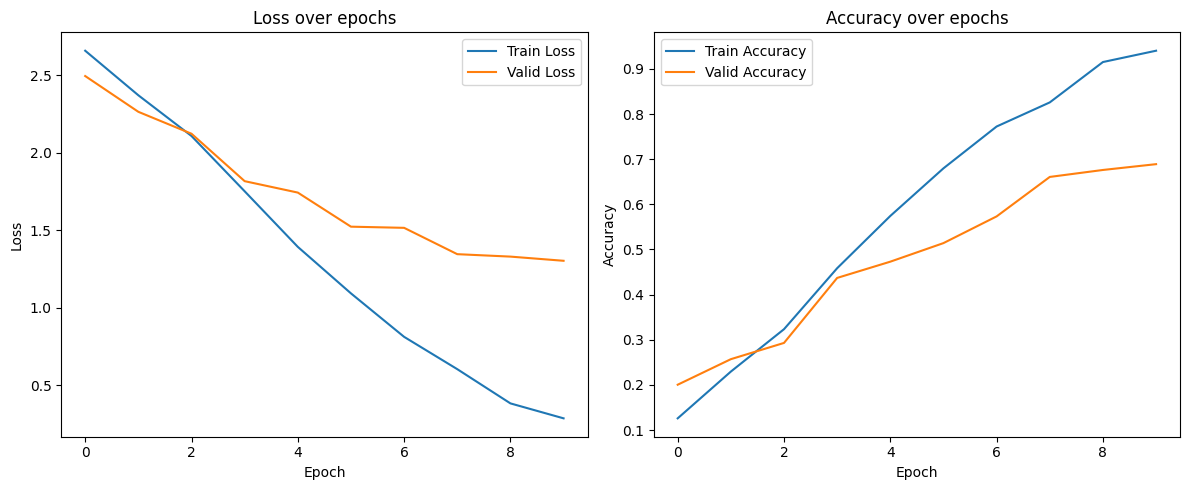

In [24]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
torch.save(model, '/content/Animal_classification.pt')

In [26]:
def predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)

    _, predicted = torch.max(outputs, 1)

    return predicted.item()

In [27]:
output=["Bear","Bird","Cat","Cow","Deer","Dog","Dolphin","Elephant","Giraffe","Horse","Kangaroo","Lion","Panda","Tiger","Zebra"]

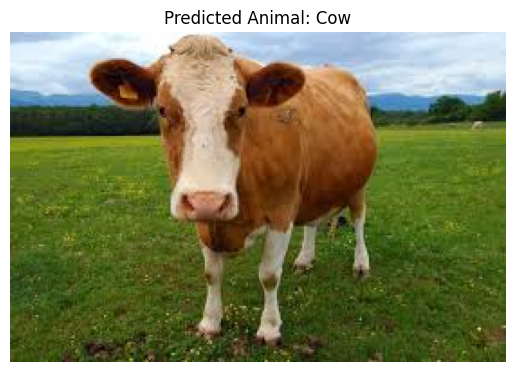

In [28]:
image_path = '/content/cow1.jpeg'
pred = predict(image_path)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted Animal: {output[pred]}')
plt.axis('off')
plt.show()

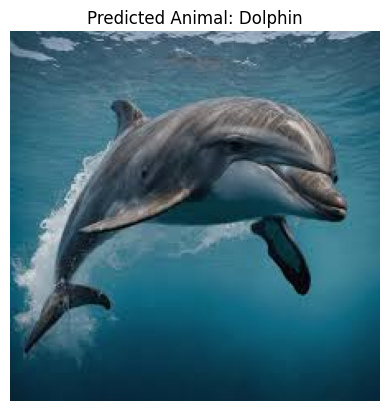

In [29]:
image_path = '/content/dolphin1.jpeg'
pred = predict(image_path)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted Animal: {output[pred]}')
plt.axis('off')
plt.show()

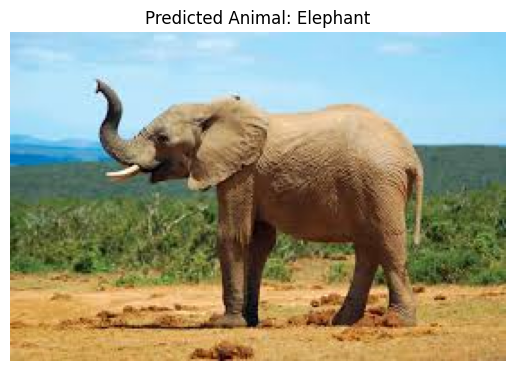

In [30]:
image_path = '/content/elephant1.jpeg'
pred = predict(image_path)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted Animal: {output[pred]}')
plt.axis('off')
plt.show()

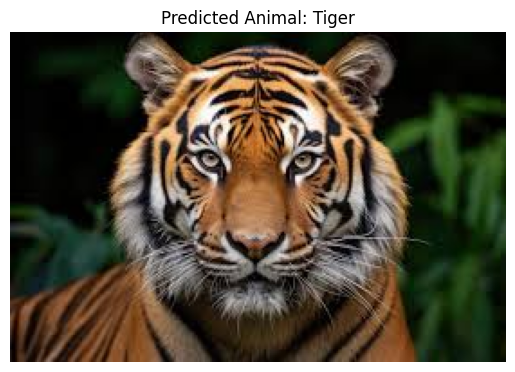

In [31]:
image_path = '/content/tiger1.jpeg'
pred = predict(image_path)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted Animal: {output[pred]}')
plt.axis('off')
plt.show()

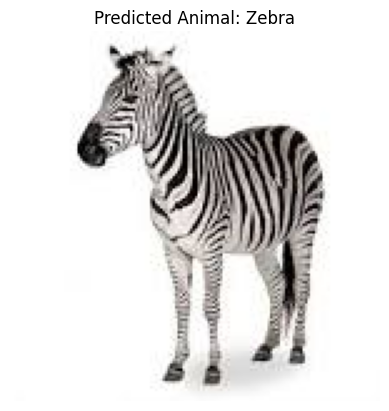

In [32]:
image_path = '/content/zebra1.jpeg'
pred = predict(image_path)
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted Animal: {output[pred]}')
plt.axis('off')
plt.show()